In [1]:
import sympy as sp
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import model as mdl
import utilities as util
%matplotlib inline
# plt.ion()
tables = mdl.get_tables()

No module named 'core'


### Forward Kinematics
For the $i$th leg represented as a the transform
$R_i$ such that $X_i = T_i 0$.

In joint variables, this turns out to be a function of $\omega_b$, $\omega_r$ and $\omega_h$

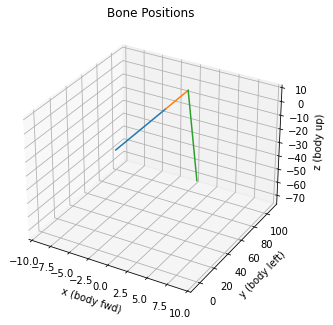

In [2]:
# Insert 3d plot here with lines at:

#   1. Foot to ankle
#   2. Ankle to knee
#   3. Knee to hip
#   4. Hip to Origin.

# Include sliders to control each joint between the ranges solved in the tables.
kinematic_chain = mdl.get_active_kinematic_chain(0,0,0)
bones = util.create_active_transform_plot(plt.figure(), kinematic_chain)
plt.show()


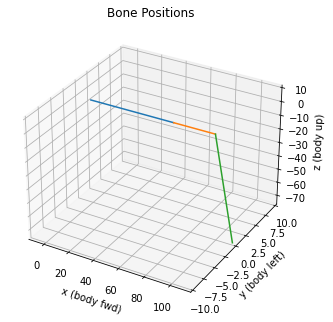

In [3]:
# insert animation of hip rotating through bounds
util.create_active_transform_animation(0)
plt.show()

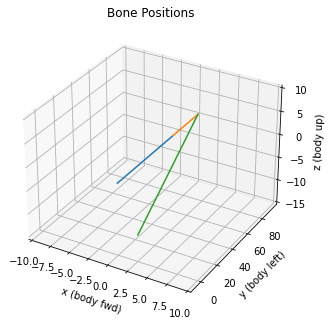

In [4]:
# insert animation of radial extension rotating through bounds
util.create_active_transform_animation(1)

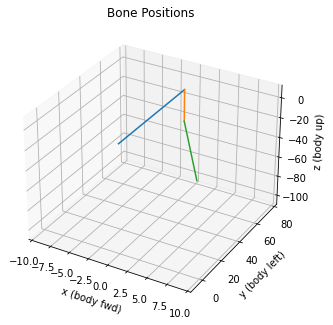

In [5]:
# insert animation of height rotating through bounds
util.create_active_transform_animation(2)

### Inverse Kinematics

The inverse kinematics are analytically solvable in the following coordinates:
 
 1. Height from rest.
 2. Body angle from joint.
 3. Radial extension.


In [11]:
# x = (57.144985, 154.152649, -70.629044)
motor_angles = [0, 0, 0]
xp = mdl.forward_kinematics(motor_angles)
print(mdl.inverse_kinematics((57.14681243, 154.118296, -68.710770)))
print(mdl.inverse_kinematics((57.14681243, 154.118296, -65.710770)))

[-0.1342837   0.00975966  0.1930489 ]
[-0.1342837   0.01904501  0.28476986]


### Motor Values

The motors drive the motion indirectly, and so we can characterise the range for which the motor values are valid, assuming the $u=0$ corresponds to a rest value of the angles. 

(-0.7407434183213392, -0.24817335554500913) (1.5707963267948966, 0.330292057264608)
(-0.6146594322240899, -0.10203780810552682) (1.5707963267948966, 0.544009616053608)
(-1.5707963267948966, -0.49824629703883416) (1.245079362710336, 0.5676021229757795)


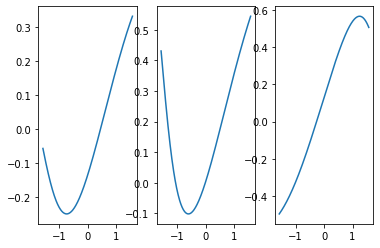

In [7]:
# Insert 3 plots, one for each motor value.
from numpy.polynomial import Polynomial as Poly

fig, axes = plt.subplots(1, 3)
n_points = 300
functions = mdl.generate_functions()
bounds = (mdl.body_angle_bounds, mdl.radial_angle_bounds, mdl.height_angle_bounds)
lower_bounds = []
upper_bounds = []
c = []
m = []
x_0 = []
py = []
px = []
for i, ax in enumerate(axes):
    x = np.linspace(bounds[i][0], bounds[i][1], n_points)
    y = np.array([functions[i](x_i) for x_i in x])
    ax.plot(x, y)
    
    p_min, = ((x_i, y_i) for x_i, y_i in zip(x,y) if y_i == y.min())
    p_max, = ((x_i, y_i) for x_i, y_i in zip(x,y) if y_i == y.max())
    i_min = np.argmin( abs(y - y.min()) )
    i_max = np.argmin( abs(y - y.max()) )
    print(p_min, p_max)
    lower_bounds.append(p_min[1])
    upper_bounds.append(p_max[1])
#     m_i = (p_max[1] - p_min[1]) / (p_max[0] - p_min[0])
#     x_0i = (p_max[0] + p_min[0]) / 2
#     x_0.append(x_0i)
#     c_i = functions[i](x_0i)
#     c.append(c_i)
#     m.append(m_i)
#     ax.plot(x, m_i*(x-x_0i) + c_i, 'r:' )
    py +=[Poly.fit(x[i_min:i_max], y[i_min:i_max], 1)]
    px += [Poly.fit(y[i_min:i_max], x[i_min:i_max], 1)]

### Leg Motion 1 - Lifting a foot.

Suppose a foot is at $r_i = T_i(w)0$ - move it directly up and down via inverse kinematics, plot 3d and motor angle.

[ 57.14681243 154.118296   -70.79757444]


Text(0.5, 1.0, 'Displacements')

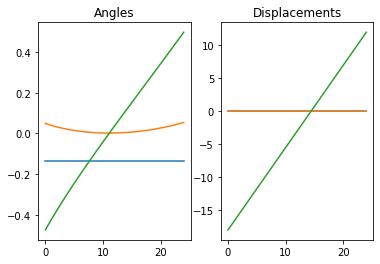

In [13]:
# get rest position 
# plot 
r = mdl.forward_kinematics(mdl.rest_angles)
print(r)
# forward pass
h = np.linspace(-18, 12, 25)
w_b = np.empty_like(h)
w_r = np.empty_like(h)
w_h = np.empty_like(h)
x = np.empty_like(h)
y = np.empty_like(h)
z = np.empty_like(h)
t = []
for i, h_i in enumerate(h):
    angles = mdl.rest_angles
    t.append(i)
    w_b[i], w_r[i], w_h[i] = mdl.inverse_kinematics((r[0], r[1], h_i + r[2]))
    x[i], y[i], z[i] = mdl.forward_kinematics((w_b[i], w_r[i], w_h[i]))
    
fig, (ax1, ax2) = plt.subplots(1, 2)


ax1.plot(t, w_b, label='Body Joint')
ax1.plot(t, w_r, label='Radial Joint')
ax1.plot(t, w_h, label='Heigh Joint')
ax1.set_title('Angles')
ax2.plot(t, x - r[0])
ax2.plot(t, y - r[1])
ax2.plot(t, z - r[2])
ax2.set_title('Displacements')

### Leg Motion 2 - Pick and place radially.
Move it out in a straight line (with respect to the body angle) by letting the height follow a quadratic, and the radial motion be linear.


### Leg Motion 3 - Pick and sweep.

Lift leg and sweep through full range of radii, with parabolic motion for height.

### Leg Motion 4 - Linear sweep.
Fix a height and move through a linear sweep.

### Leg Motion 5 - Pick and place in plane.

### Leg Motion 6 - Sweep in plane along a desired vector.

### Body Motion

1. Show 3d plot with all legs.

The contact configuration has 5 possible states, one for each leg lifted, and one for no legs lifted.

When in motion, the vehicle should attempt to move all planted legs such that the centre of mass moves at the desired linear and angular velocity. The raised leg should move such that it is as far in the direction of travel as possible whilst keeping the centre of mass withing one of the support polygons inactive support polygons. 
When the centre of mass reaches withing a threshold of the active (or any of the active) support polygons, the states should change, either by placing the lifted leg, or lifting the leg that is no longer supporting the center of mass.


In [ ]:
# plot the support ploygons of each leg underneath the 3d plot.

